

*  https://snap.stanford.edu/data/com-Amazon.html
*  https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/
*   https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/

*   https://advaitiyer.github.io/dsml/2020-01-03-adm/

* https://github.com/Advaitiyer/advanced-data-mining/blob/master/Project/aiyer01_ADM_Project_Code.ipynb
*   https://medium.com/@kumari01priyanka/ucsd-amazon-product-dataset-2018-e7613d5145b0

*   https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

*   https://github.com/soumen7saha/Network-Analysis-on-Amazon-CoPurchasing-Data/blob/main/Data%20Preprocessing%20%26%20Analysis/Data%20Preprocessing%20-%20Filtering%20Books.ipynb
*   https://www.slideshare.net/PadmaShneha/3-amazoncopurchasing-networkscnt5805research-project31pptx-228920750

*   https://rpubs.com/Ericyang95/481280


*   https://haoyingy.github.io/home/projects/Amazon-co-purchase.html
*   https://www.kaggle.com/code/idksmthnggood/market-basket-analysis



*   https://www.kaggle.com/code/yclaudel/recommendation-engine-with-networkx/notebook
*   https://towardsdatascience.com/building-a-graph-based-grocery-recommender-in-dash-on-aws-3d96d262e365



*   https://jalammar.github.io/illustrated-word2vec/
*   https://github.com/NeilSinclair/GroceryNetwork/blob/master/Basket%20Network%20Analysis-DeepWalk.ipynb



*   https://realpython.com/build-recommendation-engine-collaborative-filtering/
*   https://www.toptal.com/data-science/graph-data-science-python-networkx



*   https://towardsdatascience.com/deepwalk-its-behavior-and-how-to-implement-it-b5aac0290a15
*   List item
















In [ ]:
!pip install pyspark stemming sparknlp
import nltk
nltk.download('stopwords')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Make sure to create a new folder and change to your own directory
%cd /content/drive/Shareddrives/'DATA 245 Team 6'/Datasets/
%ls


/content/drive/Shareddrives/DATA 245 Team 6/Datasets
 amazon-books-copurchase.edgelist   books_clustering_coeff.txt   Movie_TV/
 amazon-meta.txt                    books_dict.json              rapidsai-csp-utils/
 amazon_products.pickle             books_preprocessed.csv       train_241_books_summary_review_db/
 Books_5.json.gz                    Books_rating_category.json   train_269_books_summary_review_db/
 books_amzn_meta.csv               'Dataset Links.gdoc'          train_59_books_summary_review_db/


## Import packages

In [ ]:
# Pre-processing
import glob
import random
import re
import nltk
from stemming.porter2 import stem
from nltk.corpus import stopwords
import string

# Spectral clustering
import numpy as np
import pandas as pd
import csv
import sklearn
from sklearn import cluster
import networkx as nx
import scipy
from scipy.sparse.linalg import eigs, eigsh
import matplotlib
from matplotlib import pylab
from matplotlib import pyplot as plt

# Community detection
import json

# Progress bar
from tqdm import tqdm
from time import sleep

import pickle

import os
import json
import gzip
from urllib.request import urlopen

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)


from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, HashingTF, IDF, CountVectorizer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import array_to_vector
from pyspark.mllib.evaluation import MulticlassMetrics

import pyspark.sql.functions as F
from pyspark.sql import types as T
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, ArrayType, DoubleType
from pyspark.sql.functions import length

# Spark NLP
import sparknlp
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
from pyspark.ml import Pipeline

In [ ]:
filepath = glob.glob("./amazon-meta.txt*")
fil = filepath[0]
text = open(fil,'r',encoding='utf-8',errors='ignore')

## Helpers

In [ ]:
amazon = {}
# Declaring the tuple of various feature values
(Id, ASIN, title, categories, group, connections, salesrank, tot_reviews, avg_rating, degree_centrality, clustering_coeff) = ("","","","","","", 0, 0, 0.0, 0, 0.0)

with open(fil,'r',encoding='utf-8',errors='ignore') as text:
  for line in text:
      line = line.strip()
      # Strip ID
      if(line.startswith("Id")):
          Id = line[3:].strip()
      # Strip ASIN, which is the node
      elif(line.startswith("ASIN")):
          ASIN = line[5:].strip()
      # Strip Title
      elif(line.startswith("title")):
          title = line[6:].strip()
          title = ' '.join(title.split())
      # Strip Group
      elif(line.startswith("group")):
          group = line[6:].strip()
      # Strip sales rank
      elif(line.startswith("salesrank")):
          salesrank = line[10:]
      # Strip similar, which are the connections
      elif(line.startswith("similar")):
          a = line.split()
          connections = ' '.join([i for i in a[2:]])
      # Strip categories
      elif(line.startswith("categories")):
          b = line.split()
          # Converted to lowercase
          categories = ' '.join((text.readline()).lower() for i in range(int(b[1].strip())))
          # Remove punctuations
          categories = re.compile('[%s]' % re.escape(string.digits + string.punctuation)).sub(' ', categories)
          # Remove stopwords
          categories = ' '.join(set(categories.split()) - set(stopwords.words('english')))
          # Concatenate the words
          categories = ' '.join(stem(word) for word in categories.split())
      # Count the reviews, and average rating
      elif(line.startswith("reviews")):
          c = line.split()
          tot_reviews = c[2].strip()
          avg_rating = c[7].strip()
      # Handling the exception for cases where instances are missing
      elif(line==""):
          try:
              exception = {}
              if(ASIN!=""):
                  amazon[ASIN] = exception
              exception['Id'] = Id
              exception['title'] = title
              exception['group'] = group
              exception['categories'] = ' '.join(set(categories.split()))
              exception['connections'] = connections
              exception['salesrank'] = int(salesrank)
              #exception['similar'] = ' '.join(set(connections.split()))
              exception['tot_reviews'] = int(tot_reviews)
              exception['avg_rating'] = float(avg_rating)
              exception['degree_centrality'] = degree_centrality
              exception['clustering_coeff'] = clustering_coeff
          except NameError:
              continue
          (Id, ASIN, title, categories, group, connections, salesrank, tot_reviews, avg_rating, degree_centrality, clustering_coeff) = ("","","","","","", 0, 0, 0.0, 0, 0.0)

# with open('amazon_products.pickle', 'wb') as handle:
#     pickle.dump(amazon, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('amazon_products.pickle', 'wb') as handle:
    pickle.dump(amazon, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
%ls

 amazon-meta.txt          Books_5.json.gz       Books_rating_category.json
 amazon_products.pickle   books_amzn_meta.csv  'Dataset Links.gdoc'


In [ ]:
def product_df(amzn,grp):
  prod = {}
  for key, value in amzn.items():
    # Check for the case where value is "Music", and only then choose
      if(value['group'] == grp):
          prod[key] = amzn[key]

  # Join the connections
  for key, value in prod.items():
      prod[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in prod.keys()])

  # Convert to dataframe
  prod_df = pd.DataFrame.from_dict(prod)
  prod_df = prod_df.transpose()

  return prod,prod_df

## Export and import files

In [ ]:
with open('amazon_products.pickle', 'rb') as handle:
    amzn = pickle.load(handle)

In [ ]:
# meta_df = pd.DataFrame(amzn).T
# meta_df.query("group in ('Book','DVD','Video','Music')").groupby('group').size().plot.bar()

In [ ]:
# Subset of music products in the dataset
# music = product_df("Music")
# len(music) #103144

In [ ]:
# Subset of books
books_dict,books = product_df(amzn, "Book")
len(books) #393561

#books.to_csv("books_amzn_meta.csv")

393561

In [ ]:
%pwd

'/content/drive/Shareddrives/DATA 245 Team 6/Datasets'

In [ ]:
books_meta = pd.read_csv("/content/drive/Shareddrives/DATA 245 Team 6/Datasets/books_amzn_meta.csv").rename(columns={'Unnamed: 0':"asin"})

In [ ]:
books_meta.head()

In [ ]:
books_dict

In [ ]:
#books_meta = books_meta.drop('similar',axis=1)

In [ ]:
# Subset of Video
# video = product_df("Video")
# len(video) #26131

In [ ]:
# Subset of DVD
# dvd = product_df("DVD")
# len(dvd) #19828

In [ ]:


# ### load the meta data
# array= []
# count = 1

# # Create a JSON file to store the extracted data
# jsonFile = open("./Books_rating_category.json", "w")
# jsonFile.write("[") # Opening bracket to denote a list of JSON objects

# # Open the gzipped file and extract the required fields
# with gzip.open('Books_5.json.gz') as f:
#     for l in f:
#         # Load each line as a JSON object
#         d = json.loads(l.strip())

#         # Check if the required fields are present in the JSON object
#         if 'reviewText' in d and 'asin' in d and 'overall' in d and 'reviewerID' in d and 'summary' in d:
#             et_dict = {"asin":  d["asin"],
#                         "overall" : d["overall"],
#                         "reviewText" : d["reviewText"],
#                         "reviewerID" : d["reviewerID"],
#                         "summary" : d["summary"],}
#             # Append the extracted fields to the array
#             array.append(et_dict)
#             # Convert the dictionary to a JSON string
#             jsonString = json.dumps(et_dict)+",\n"
#             # Write the JSON string to the file
#             jsonFile.write(jsonString)

# # Closing bracket to denote the end of the list of JSON objects
# jsonFile.write("]")
# # Close the JSON file
# jsonFile.close()

## PySpark processing

In [ ]:
from pyspark.sql import SparkSession

# create a SparkSession
spark = SparkSession.builder.appName("booksSpark").getOrCreate()


In [ ]:
#spark.stop()

In [ ]:
%pwd

'/content/drive/Shareddrives/DATA 245 Team 6/Datasets'

In [ ]:
# read a JSON file into a DataFrame
df = spark.read.json("/content/drive/Shareddrives/DATA 245 Team 6/Datasets/Books_rating_category.json")

# show the first 10 rows of the DataFrame
df.show(10)

+--------------------+----------+-------+--------------------+--------------+--------------------+
|     _corrupt_record|      asin|overall|          reviewText|    reviewerID|             summary|
+--------------------+----------+-------+--------------------+--------------+--------------------+
|[{"asin": "000171...|      NULL|   NULL|                NULL|          NULL|                NULL|
|                NULL|0001713353|    5.0|  The kids loved it!| AVP0HXC9FG790|          Five Stars|
|                NULL|0001713353|    5.0|My students (3 & ...|A324TTUBKTN73A|          Five Stars|
|                NULL|0001713353|    5.0|             LOVE IT|A2RE7WG349NV5D|          Five Stars|
|                NULL|0001713353|    5.0|              Great!|A32B7QIUDQCD0E|          Five Stars|
|                NULL|0001713353|    5.0|Over and over the...|A3H9YD6K9TVKDP|       Not Nice Mice|
|                NULL|0001713353|    5.0|I remember readin...| A3M314LI9OYME|One of my favorit...|
|         

In [ ]:
books_meta = pd.read_csv("books_preprocessed.csv").rename(columns={'Unnamed: 0':'asin'}).drop('degree_centrality',axis=1)
books_meta.columns

Index(['asin', 'Id', 'title', 'group', 'categories', 'connections',
       'salesrank', 'tot_reviews', 'avg_rating', 'clustering_coeff',
       'DegreeCentrality'],
      dtype='object')

In [ ]:
books_meta_spark =spark.createDataFrame(books_meta)
books_meta_spark.printSchema()
books_meta_spark.show()

root
 |-- asin: string (nullable = true)
 |-- Id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- group: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- connections: string (nullable = true)
 |-- salesrank: long (nullable = true)
 |-- tot_reviews: long (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- clustering_coeff: double (nullable = true)
 |-- DegreeCentrality: long (nullable = true)

+----------+---+--------------------+-----+--------------------+--------------------+---------+-----------+----------+----------------+----------------+
|      asin| Id|               title|group|          categories|         connections|salesrank|tot_reviews|avg_rating|clustering_coeff|DegreeCentrality|
+----------+---+--------------------+-----+--------------------+--------------------+---------+-----------+----------+----------------+----------------+
|0827229534|  1|Patterns of Preac...| Book|subject religion ...|0804215715 156101...|   3965

In [ ]:
print((books_meta_spark.count(), len(books_meta_spark.columns)))


(393561, 11)


In [ ]:
book_meta_asin = books_meta_spark.select("asin").distinct().rdd.map(lambda r: r.asin).collect()

In [ ]:
book_review_asin = df.select('asin').distinct().rdd.map(lambda r: r.asin).collect()

In [ ]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

common_asin  = intersection(book_review_asin, book_meta_asin)
len(common_asin)

33838

In [ ]:
books_nx_reviews = books_meta_spark.join(df,['asin'],"inner")

In [ ]:
books_nx_reviews.show(5)

+----------+------+--------------------+-----+--------------------+--------------------+---------+-----------+----------+----------------+----------------+---------------+----------+-------+--------------------+--------------+--------------------+
|      asin|    Id|               title|group|          categories|         connections|salesrank|tot_reviews|avg_rating|clustering_coeff|DegreeCentrality|_corrupt_record|      asin|overall|          reviewText|    reviewerID|             summary|
+----------+------+--------------------+-----+--------------------+--------------------+---------+-----------+----------+----------------+----------------+---------------+----------+-------+--------------------+--------------+--------------------+
|0002171856|300284|The SAS Survival ...| Book|camp outdoor subj...|1585740608 158574...|   381361|         34|       4.5|             0.9|               4|           NULL|0002171856|    5.0|       Good product.|A2T2KN06Q8R4KE|       Good product.|
|0002171

In [ ]:
books_nx_reviews.printSchema()

root
 |-- asin: string (nullable = true)
 |-- Id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- group: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- connections: string (nullable = true)
 |-- salesrank: long (nullable = true)
 |-- tot_reviews: long (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- clustering_coeff: double (nullable = true)
 |-- DegreeCentrality: long (nullable = true)
 |-- _corrupt_record: string (nullable = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- summary: string (nullable = true)



In [ ]:
books_nx_reviews.select("avg_rating", "clustering_coeff","DegreeCentrality").describe().show(truncate=8)

+-------+----------+----------------+----------------+
|summary|avg_rating|clustering_coeff|DegreeCentrality|
+-------+----------+----------------+----------------+
|  count|   1183198|         1183198|         1183198|
|   mean|  4.223...|        0.659...|        10.00...|
| stddev|  0.742...|        0.287...|        13.66...|
|    min|       0.0|             0.0|               0|
|    max|       5.0|             1.0|             224|
+-------+----------+----------------+----------------+



In [ ]:
print((books_nx_reviews.count(), len(books_nx_reviews.columns)))


(1183198, 17)


In [ ]:
books_ex = books_nx_reviews.filter(books_nx_reviews.asin == "0932081258").toPandas()

In [ ]:
books_ex.title.unique()

array([], dtype=object)

In [ ]:
books_ex['reviewText'].values

array([], dtype=object)

In [ ]:
stopwords.add("book")
wordcloud = WordCloud(
    background_color = 'black',
    width = 1000,
    height = 500,
    stopwords = stopwords).generate(str(books_ex['reviewText'].values))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams["figure.figsize"] = [10, 10]

ValueError: ignored

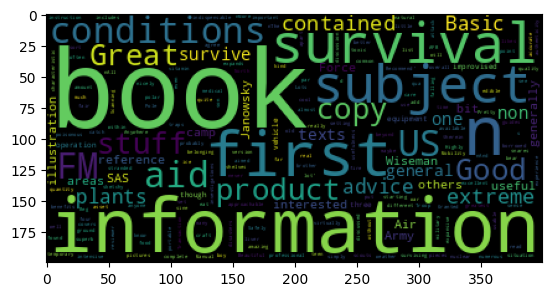

In [ ]:
wordcloud = WordCloud().generate(str(books_ex['reviewText'].values))

plt.imshow(wordcloud)

## Network analysis

In [ ]:
from itertools import islice

def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

take(3,books_dict.items())[0][1]['categories']

'subject religion sermon preach christian book spiritu clergi'

In [ ]:
Copurchase_Graph = nx.Graph()
for asin, metadata in books_dict.items():
    Copurchase_Graph.add_node(asin)
    for a in metadata['connections'].split():
        Copurchase_Graph.add_node(a.strip())
        similarity = 0
        n1 = set((books_dict[asin]['categories']).split())
        n2 = set((books_dict[a]['categories']).split())
        n1In2 = n1 & n2
        n1Un2 = n1 | n2
        if(len(n1In2)) > 0:
            similarity = round(len(n1In2) / len(n1Un2), 2)
            #print(similarity)
            Copurchase_Graph.add_edge(asin, a.strip(), weight = similarity)

In [ ]:
dc = nx.degree(Copurchase_Graph)
for asin in nx.nodes(Copurchase_Graph):
    metadata = books_dict[asin]
    metadata['DegreeCentrality'] = int(dc[asin])
    ego = nx.ego_graph(Copurchase_Graph, asin, radius = 1)
    cluster_coeff = round(nx.average_clustering(ego), 2)
    #print(cluster_coeff)
    metadata['clustering_coeff'] = cluster_coeff
    books_dict[asin] = metadata

In [ ]:
Amazon_Books_File = open('books_clustering_coeff.txt', 'w', encoding = 'utf-8', errors = 'ignore')

Amazon_Books_File.write("Id\t" + "ASIN\t" + "title\t" + "categories\t" + "group\t" + "similar\t" + "salesrank\t" + "tot_reviews\t" + "avg_rating\t" "degree_centrality\t" +
                        "clustering_coeff\n")

for asin, metadata in books_dict.items(): # converting the meta-data into txt file
     Amazon_Books_File.write(metadata['Id'] + "\t" + \
                             asin + "\t" +  \
                             metadata['title'] + "\t" + \
                             metadata['categories'] + "\t" + \
                             metadata['group'] + "\t" +  \
                             metadata['similar'] + "\t" + \
                             str(metadata['salesrank']) + "\t" + \
                             str(metadata['tot_reviews']) + "\t" +
                             str(metadata['avg_rating']) + "\t" + \
                             str(metadata['degree_centrality']) + "\t" + \
                             str(metadata['clustering_coeff']) + "\n")

Amazon_Books_File.close()

In [ ]:
# writing the adjacency edge list
Amazon_Books_File = open("amazon-books-copurchase.edgelist", 'wb')
nx.write_weighted_edgelist(Copurchase_Graph, Amazon_Books_File)
Amazon_Books_File.close()

In [ ]:
%ls

 amazon-books-copurchase.edgelist   Books_5.json.gz              Books_rating_category.json
 amazon-meta.txt                    books_amzn_meta.csv         'Dataset Links.gdoc'
 amazon_products.pickle             books_clustering_coeff.txt


### Read in clustering coeff file

In [ ]:
take(3,books_dict.items())[0][1]

NameError: ignored

In [ ]:
Books_File = open('books_clustering_coeff.txt', 'r', encoding = 'utf-8', errors = 'ignore')
Books = {}
Books_File.readline()
for line in Books_File:
    cell = line.split("\t")
    MetaData = {}
    MetaData['Id'] = cell[0].strip()
    ASIN = cell[1].strip()
    MetaData['title'] = cell[2].strip()
    MetaData['categories'] = cell[3].strip()
    MetaData['group'] = cell[4].strip()
    MetaData['similar'] = cell[5].strip()
    MetaData['salesrank'] = int(cell[6].strip())
    MetaData['tot_reviews'] = int(cell[7].strip())
    MetaData['avg_rating'] = float(cell[8].strip())
    MetaData['degree_centrality'] = int(cell[9].strip())
    MetaData['clustering_coeff'] = float(cell[10].strip())
    Books[ASIN] = MetaData
Books_File.close()

In [ ]:
Books_File = open("amazon-books-copurchase.edgelist", "rb")
Copurchase_Graph = nx.read_weighted_edgelist(Books_File)
Books_File.close()

In [ ]:
Copurchase_Graph = nx.read_weighted_edgelist("amazon-books-copurchase.edgelist")

## Recommendation

In [ ]:
print("Looking for Recommendations for Customer Purchasing this Book: ")
print("---------------------------------------------------------------")
Purchased_ASIN = '0805047905'
print("ASIN = ", Purchased_ASIN)
print("title = ", Books[Purchased_ASIN]['title'])
print("salesrank = ", Books[Purchased_ASIN]['salesrank'])
print("tot_reviews = ", Books[Purchased_ASIN]['tot_reviews'])
print("avg_rating = ", Books[Purchased_ASIN]['avg_rating'])
print("degree_centrality = ", Books[Purchased_ASIN]['degree_centrality'])
print("clustering_coeff = ", Books[Purchased_ASIN]['clustering_coeff'])

Looking for Recommendations for Customer Purchasing this Book: 
---------------------------------------------------------------
ASIN =  0805047905
title =  Brown Bear, Brown Bear, What Do You See?
salesrank =  171
tot_reviews =  172
avg_rating =  5.0
degree_centrality =  5
clustering_coeff =  0.0


In [ ]:
Purchased_ASIN in list(Copurchase_Graph.nodes)

True

In [ ]:
ego = nx.ego_graph(Copurchase_Graph, Purchased_ASIN, radius = 1)
Purchased_ASIN_Ego_Graph = nx.Graph(ego)

In [ ]:
threshold = 0.5 # finding the nodes having similarity measure based on category above the threshold value
Purchased_ASIN_Ego_Trim_Graph = nx.Graph()
for f, t, e in Purchased_ASIN_Ego_Graph.edges(data = True):
    if e['weight'] >= threshold:
        Purchased_ASIN_Ego_Trim_Graph.add_edge(f, t)

In [ ]:
Purchased_ASIN_Neighbors = Purchased_ASIN_Ego_Trim_Graph.neighbors(Purchased_ASIN)


In [ ]:
ASIN_Meta = []
for asin in Purchased_ASIN_Neighbors:
    ASIN = asin
    Title = books_dict[ASIN]['title']
    SalesRank = books_dict[ASIN]['salesrank']
    TotalReviews = books_dict[ASIN]['tot_reviews']
    AvgRating = books_dict[ASIN]['avg_rating']
    DegreeCentrality = books_dict[ASIN]['degree_centrality']
    ClusteringCoeff = books_dict[ASIN]['clustering_coeff']
    ASIN_Meta.append((ASIN, Title, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff))

In [ ]:
Top5_ByAbgRating_ThenByTotalReviews = sorted(ASIN_Meta, key = lambda x: (x[4], x[3]), reverse = True)[:5]
print()
print("Top 5 Recommendations By AvgRating Then By TotalReviews for Users Purchased The Book: ")
print("--------------------------------------------------------------------------------------")
print('ASIN\t', 'title\t', 'salesrank\t', 'tot_reviews\t', 'avg_rating\t', 'degree_centrality\t', 'clustering_coeff')
for asin in Top5_ByAbgRating_ThenByTotalReviews:
    print(asin)

print()


Top 5 Recommendations By AvgRating Then By TotalReviews for Users Purchased The Book: 
--------------------------------------------------------------------------------------
ASIN	 title	 salesrank	 tot_reviews	 avg_rating	 degree_centrality	 clustering_coeff
('0152010661', 'Time for Bed', 3122, 87, 5.0, 0, 0.57)
('0694006246', 'Big Red Barn Board Book', 4457, 40, 5.0, 0, 0.57)
('1581170769', 'What Makes a Rainbow?: Pop-Up', 40821, 29, 5.0, 0, 0.8)
('0064435962', 'From Head to Toe', 187777, 22, 5.0, 0, 0.93)
('0060235152', 'From Head to Toe', 43438, 22, 5.0, 0, 0.93)



##  Advaitiyer/advanced-data-mining

In [ ]:
# # Evaluating the similarity between two connected nodes
# connections_graph = nx.Graph()
# # Add the nodes
# for key, value in amzn.items():
#   connections_graph.add_node(key)
#   for i in value['connections'].split():
#     # Add the respective connected nodes
#     connections_graph.add_node(i.strip())
#     similarity = 0
#     try:
#       # Set of words in the node's categorical description
#       set_1 = set(amzn[key]['categories'].split())
#       # Set of words is node's connections' categorical description
#       set_2 = set(amzn[i]['categories'].split())
#     except KeyError:
#       continue
#     # Calculating intersection and union
#     union = set_1 & set_2
#     intersection = set_1 | set_2
#     if(len(union)) > 0:
#       # Similarity is the ratio of intersection with union. The more common items, the higher the intersection, and similarity
#       similarity = round(len(intersection)/len(union),2)
#     connections_graph.add_edge(key, i.strip(), weight=similarity)

# A = nx.adjacency_matrix(connections_graph)

# L = nx.laplacian_matrix(connections_graph)


In [ ]:
# Due to the large size of the data, computing only top 200 eigenvalues/eigenvectors
# eigenvalues, eigenvectors = eigsh(L, k=200, which='LM', return_eigenvectors=True)
# # Sorting the eigenvectors on the basis of sorted eigenvalues' keys
# ids = eigenvalues.argsort()[::-1]
# eigenvalues = eigenvalues[ids]
# plt.plot(eigenvalues)

# eigenvectors = eigenvectors[:, ids]

In [ ]:
# Evaluating the degree of the nodes of connections
# deg_central = nx.degree(connections_graph)
# for key in nx.nodes(connections_graph):
#   try:
#     value = amzn[key]
#   except KeyError:
#     continue
#   # Degree centrality is the integer value of deg_central
#   value['degree_centrality'] = int(deg_central[key])
#   #
#   ego = nx.ego_graph(connections_graph, key, radius=1)
#   # Evaluating the clustering coefficient by
#   value['clustering_coeff'] = round(nx.average_clustering(ego),2)
#   amzn[key] = value

# # Printing the weights of each of each 150th node
# count = 0
# for f,t,e in connections_graph.edges(data=True):
#   if count == 150:
#     break
#   print(e['weight'])
#   count +=1

In [ ]:
# items = list(amzn.items())

# # Converting the dictionary into a dataframe
# ls = []
# for i, j in enumerate(items):
#     colnames = list(j[1])
#     colnames.append("ASIN")
#     vals = list(j[1].values())
#     vals.append(j[0])
#     ls.append(vals)
# df_meta = pd.DataFrame(ls, columns=colnames)

# # Choosing salesrank, total reviews, average rating, degree centrality, and clustering coefficient columns
# # df.head()
# df_new = df_meta[["salesrank","tot_reviews","avg_rating","degree_centrality","clustering_coeff"]]
# for i in range(len(df_new['salesrank'])):
#     if df_new['salesrank'][i] == 0:
#         df_new = df_new.drop(i)

# clustering_coeff_sorted = df_meta.sort_values('clustering_coeff', ascending=False)

In [ ]:
with open("books_dict.json", "w") as outfile:
    outfile.write(json.dumps(books_dict, indent=4))

In [ ]:
books_df = pd.DataFrame.from_dict(books_dict)
books_df = books_df.transpose()

In [ ]:
books_df.shape

(393561, 11)

In [ ]:
books_df

,Id,title,group,categories,connections,salesrank,tot_reviews,avg_rating,degree_centrality,clustering_coeff,DegreeCentrality
0827229534,1,Patterns of Preaching: A Sermon Sampler,Book,subject religion sermon preach christian book ...,0804215715 156101074X 0687023955 0687074231 08...,396585,2,5.0,0,0.8,8
0738700797,2,Candlemas: Feast of Flames,Book,spiritu subject religion witchcraft wicca book...,0738700827 1567184960 1567182836 0738700525 07...,168596,12,4.5,0,0.85,9
0486287785,3,World War II Allied Fighter Planes Trading Cards,Book,subject hobbi home garden craft general book,,1270652,1,5.0,0,0.0,0
0842328327,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,sacr applic general histori religion studi sub...,0842328130 0842330313 0842328610 0842328572,631289,1,4.0,0,0.79,6
1577943082,5,Prayers That Avail Much for Business: Executive,Book,subject religion busi devot prayerbook worship...,157794349X 0892749504 1577941829 0892749563,455160,0,0.0,0,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...
9700507734,548541,Para alcanzar el orgasmo,Book,bodi subject health general book mind,,0,1,4.0,0,0.0,0
9627762644,548542,Starting a Hedge Fund : A US Perspective,Book,subject invest busi general book,,0,3,2.5,0,0.0,0
0970020503,548543,Facts Every Injured Worker Should Know,Book,subject employ busi guid labor law general boo...,,0,5,4.5,0,0.0,0
1930519206,548546,Adobe Photoshop 6 VTC Training CD,Book,store illustr applic comput develop subject ad...,,0,2,5.0,0,0.0,0


In [ ]:
books_df.to_csv("books_preprocessed.csv")

## Unmount

In [ ]:
drive.flush_and_unmount()
